# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 




### Import Packages

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

### Read an input Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


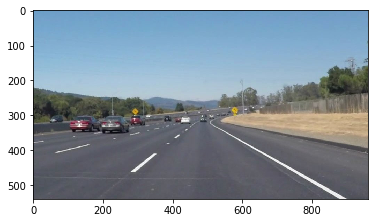

In [4]:
#reading in an image
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
#image = mpimg.imread('test_images/solidYellowCurve.jpg')
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')
#image = mpimg.imread('test_images/solidYellowLeft.jpg')
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


### Helper Functions

Helper functions provided:

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, drawf=draw_lines):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    drawf(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Building a Lane Finding Pipeline


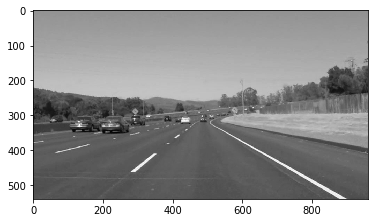

In [7]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#image = mpimg.imread('test_images/solidWhiteRight.jpg')  # [1]
image = mpimg.imread('test_images/solidWhiteCurve.jpg')  # [2]
#image = mpimg.imread('test_images/solidYellowCurve.jpg')  # [3]
#image = mpimg.imread('test_images/solidYellowCurve2.jpg')  # [4]
#image = mpimg.imread('test_images/solidYellowLeft.jpg')  # [5]
#image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')  # [6]

# start with grayscale
grayimage = grayscale(image)
plt.imshow(grayimage, cmap='gray')
mpimg.imsave("output_images/2_1_grayimage.png", grayimage, cmap='gray')

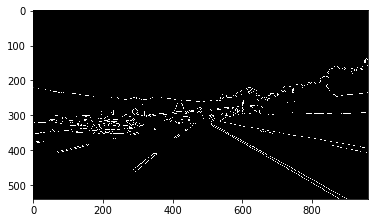

In [8]:
# continue preparing image
tmpimage = gaussian_blur(grayimage, 5)
tmpimage2 = canny(tmpimage, 50, 150)
plt.imshow(tmpimage2, cmap='gray')
mpimg.imsave("output_images/2_2_gradient.png",tmpimage2, cmap='gray')

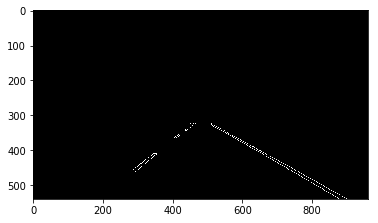

In [9]:
# mask with a trapezoid and the function "bitwise_and"
imshape = tmpimage.shape
deltax1 = 0.01
deltax2 = 0.05
deltay = 1.15
center = (imshape[1]/2, imshape[0]/2)
p1 = (center[0]*(1-deltax1), center[1]*deltay)
p2 = (imshape[1]*deltax2, imshape[0])
p3 = (imshape[1]*(1-deltax2), imshape[0])
p4 = (center[0]*(1+deltax1), center[1]*deltay)
vertices = np.array([[p1,p2,p3,p4]], dtype=np.int32)
maskedimage = region_of_interest(tmpimage2, vertices)
mpimg.imsave("output_images/2_3_masked.png", maskedimage)
plt.imshow(maskedimage, cmap='gray')

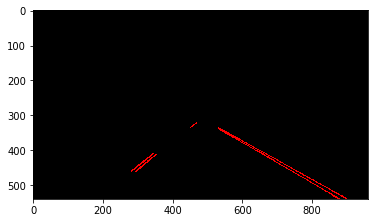

In [10]:
rho = 1
theta = np.pi/180
threshold = 3
min_line_length = 15
max_line_gap = 5

line_image = hough_lines(maskedimage, rho, theta, threshold, min_line_length, max_line_gap)
plt.imshow(line_image)
mpimg.imsave("output_images/2_4_mask_in_red.png", line_image)

In [11]:
#color_edges = np.dstack((tmpimage2, tmpimage2, tmpimage2)) 
#color_edges = np.dstack((tmpimage, tmpimage, tmpimage)) 
#color_edges = np.dstack((image, image, image)) 
#color_edges = np.concatenate(tmpimage2)

In [12]:
#lines_edges = weighted_img(color_edges, line_image)
#image_with_lines = weighted_img(image, line_image)
#plt.imshow(image_with_lines)

### Improving the draw_lines() function

In [13]:
# new draw_line function
def draw_left_right_lines(img, lines, color=[255, 0, 0], thickness=8):
    left_line = np.array([])
    right_line = np.array([])
    
    leftx = img.shape[1]
    lefty = 0
    lefta = np.array([])
    leftb = np.array([])
    
    #rightx = img.shape[1]
    rightx = 0
    righty = img.shape[0]
    righta = np.array([])
    rightb = np.array([])
    for line in lines:
        for x1,y1,x2,y2 in line:
            a = (y2-y1)/(x2-x1)
            b = y1 - a*x1
            if a > 0:
                # left
                lefta = np.append(lefta, a)
                leftb = np.append(leftb, b)
                leftx = min(leftx, x1, x2)
                lefty = max(lefty, y1, y2)
            elif a < 0:
                # right
                righta = np.append(righta, a)
                rightb = np.append(rightb, b)
                rightx = max(rightx, x1, x2)
                righty = min(righty, y1, y2)
            else:
                #print("slope = zero")
                pass

                
                
    # the "left" line is drawn as "right" because the image has y+ down
    la = np.average(lefta)
    lb = np.average(leftb)
    
    # the "right" line is drawn as "left" because the image has y+ down
    ra = np.average(righta)
    rb = np.average(rightb)
    
    # looking for the intersection of the two lines
    a = (rb-lb)/(la-ra)
    if not math.isnan(a):
        rx2i = math.ceil(a)
        ry2i = math.ceil(la*rx2i-lb)
    else:
        # a is NaN
        rx2i = 0
        ry2i = 0
    
    # intersection: left = right
    lx2i = rx2i
    ly2i = ry2i
    
    # left p1 (bottom)
    ly1 = img.shape[0]
    
    # check for invalid data or la = 0
    if not math.isnan((ly1-lb)/la):
        lx1 = math.ceil((ly1-lb)/la)
    else:
        lx1 = 0
    # left p2 (center)
    lx2 = math.ceil(leftx)
    lx2 = max(lx2, lx2i)  # consider intersection
    if not math.isnan(la*lx2 + lb):
        ly2 = math.ceil(la*lx2 + lb)
    else:
        ly2 = 0
    
    # right p1 (bottom)
    ry1 = img.shape[0]
    # check for invalid data or ra = 0
    if not math.isnan((ry1-rb)/ra):
        rx1 = math.ceil((ry1-rb)/ra)
    else:
        rx1 = 0
    
    # right p2 (center)
    rx2 = math.ceil(rightx)
    rx2 = min(rx2, rx2i)  # consider intersection
    if not math.isnan(ra*rx2 + rb):
        ry2 = math.ceil(ra*rx2 + rb)
    else:
        ry2 = 0
    
    # consider the intersection
    #lx2 = min(lx2, lx2i)
    #ly2 = min(ly2, ly2i)
    #rx2 = min(rx2, rx2i)
    #ry2 = min(ry2, ry2i)

    #print(la, lb, ra, rb)
    #print('intersection: ', lx2i, ly2i) 
    #print(lx1,ly1,lx2,ly2)
    #print(rx1,ry1,rx2,ry2)
    
    # plot
    cv2.line(img, (lx1, ry1), (lx2, ly2), color, thickness)
    cv2.line(img, (rx1, ry1), (rx2, ry2), color, thickness)

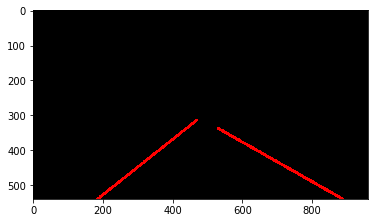

In [14]:

left_right_image = hough_lines(maskedimage, rho, theta, threshold, min_line_length, max_line_gap, drawf=draw_left_right_lines)
plt.imshow(left_right_image)
mpimg.imsave("output_images/2_5_mask_red_continuous.png", left_right_image)

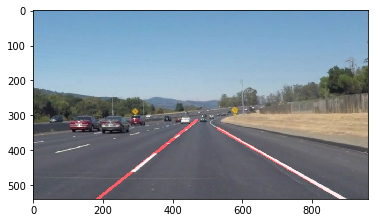

In [15]:
color_edges2 = np.dstack((image, image, image)) 
image_left_right = weighted_img(image, left_right_image)
plt.imshow(image_left_right)
mpimg.imsave("output_images/2_6_final.png", image_left_right)

## Test on Videos

The moviepy module makes possible to process each frame as an image.

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    tmpimage0 = grayscale(image)
    tmpimage1 = gaussian_blur(tmpimage0, 5)
    tmpimage2 = canny(tmpimage1, 50, 150)
    
    # calculate vertices of trapezoid
    imshape = tmpimage1.shape
    deltax1 = 0.01 # parameter to find the center
    deltax2 = 0.05 # parameter to find the center
    deltay = 1.15  # parameter to find the center
    center = (imshape[1]/2, imshape[0]/2)
    p1 = (center[0]*(1-deltax1), center[1]*deltay)
    p2 = (imshape[1]*deltax2, imshape[0])
    p3 = (imshape[1]*(1-deltax2), imshape[0])
    p4 = (center[0]*(1+deltax1), center[1]*deltay)
    vertices = np.array([[p1,p2,p3,p4]], dtype=np.int32)
    
    # select region inside trapezoid
    maskedimage = region_of_interest(tmpimage2, vertices)

    rho = 1
    theta = np.pi/180
    threshold = 3
    min_line_length = 15
    max_line_gap = 5
    # segments
    line_image = hough_lines(maskedimage, rho, theta, threshold, min_line_length, max_line_gap)
    # continous
    #line_image = hough_lines(maskedimage, rho, theta, threshold, min_line_length, max_line_gap, drawf=draw_left_right_lines)

    result = weighted_img(image, line_image)

    return result

Modified function to process the image from video:

In [18]:
def process_image_continuous(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    tmpimage0 = grayscale(image)
    tmpimage1 = gaussian_blur(tmpimage0, 5)
    tmpimage2 = canny(tmpimage1, 50, 150)
    
    # calculate vertices of trapezoid
    imshape = tmpimage1.shape
    deltax1 = 0.01 # parameter to find the center
    deltax2 = 0.05 # parameter to find the center
    deltay = 1.15  # parameter to find the center
    center = (imshape[1]/2, imshape[0]/2)
    p1 = (center[0]*(1-deltax1), center[1]*deltay)
    p2 = (imshape[1]*deltax2, imshape[0])
    p3 = (imshape[1]*(1-deltax2), imshape[0])
    p4 = (center[0]*(1+deltax1), center[1]*deltay)
    vertices = np.array([[p1,p2,p3,p4]], dtype=np.int32)
    
    # select region inside trapezoid
    maskedimage = region_of_interest(tmpimage2, vertices)

    rho = 1
    theta = np.pi/180
    threshold = 3
    min_line_length = 15
    max_line_gap = 5
    # segments
    #line_image = hough_lines(maskedimage, rho, theta, threshold, min_line_length, max_line_gap)
    # continous
    line_image = hough_lines(maskedimage, rho, theta, threshold, min_line_length, max_line_gap, drawf=draw_left_right_lines)

    result = weighted_img(image, line_image)

    return result

Read and process:

In [19]:
white_output = 'output_video/solidWhiteRight_segments.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_video/solidWhiteRight_segments.mp4
[MoviePy] Writing video output_video/solidWhiteRight_segments.mp4


100%|█████████▉| 221/222 [00:07<00:00, 30.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/solidWhiteRight_segments.mp4 

CPU times: user 2.7 s, sys: 320 ms, total: 3.02 s
Wall time: 8.32 s


In [20]:
%%HTML
<video width="320" height="240" controls>
  <source src="./output_video/solidWhiteRight_continuous.mp4" type="video/mp4">
</video>